In [1]:
'''
Enviroment: Ubuntu 16.04 + TensorFlow 1.12.0 + cuda 9.0 + python 3.6
Dataset: Cityscapes, https://www.kaggle.com/dansbecker/cityscapes-image-pairs
Segmentation Model: UNet 
Adversarial Model: NN
Metric: Mean Intersection over Union(MIoU)=TP/(TP+FN+FP)
'''
import numpy as np
import argparse
import json
from os.path import join
import tensorflow as tf
import glob
from PIL import Image , ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.eager as tfe
import sys
print(tf.VERSION) 
print(sys.version)

1.12.0
3.6.6 (default, Jun 28 2018, 04:42:43) 
[GCC 5.4.0 20160609]


In [22]:
#binarize the value of label to 0 or 1
def binarize( pixel ):
    if np.array_equal( pixel , [ 128 , 63 , 127 ]): #road
        return np.array( [ 1 ] )
    else :
        return np.array( [ 0 ] )
#train set
def trainDataset(train_dir):
    X_train = list()
    Y_train = list()
    for filename in os.listdir( train_dir ): 
        image = Image.open(os.path.join( train_dir, filename))
        X_train.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) ) #real image
        Y_train.append( np.asarray( ImageOps.crop( image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) )) #labelled image
    return np.array(X_train)/255, np.array(Y_train)
train_dir = '/data/comcode/models/research/deeplab/datasets/cityscapes/kaggle/train'
X_train, Y_train = trainDataset(train_dir)
Y_train = np.apply_along_axis( binarize , axis=3 , arr=np.array(Y_train) ) #classify the pixel
print ('The size of feature in Train set is : {}'.format(X_train.shape))
print ('The size of label in Train set is : {}'.format(Y_train.shape))

#val set
def valDataset(val_dir):
    X_val = list()
    Y_val = list()
    for filename in os.listdir( val_dir ): 
        image = Image.open(os.path.join( val_dir, filename))
        X_val.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
        Y_val.append( np.asarray( ImageOps.crop( image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))
    return np.array(X_val)/255, np.array(Y_val)
val_dir = '/data/comcode/models/research/deeplab/datasets/cityscapes/kaggle/val'
X_val,Y_val = valDataset(val_dir)
Y_val = np.apply_along_axis( binarize , axis=3 , arr=np.array(Y_val) ) #classify the pixel
print ('The size of feature in Val set is: {}'.format(X_val.shape))
print ('The size of label in Val set is : {}'.format(Y_val.shape))

The size of feature in Train set is : (2975, 128, 128, 3)
The size of label in Train set is : (2975, 128, 128, 1)
The size of feature in Val set is: (500, 128, 128, 3)
The size of label in Val set is : (500, 128, 128, 1)


In [23]:
class unet_seg:
    def __init__(self, lr=0.001):
        #global parameters
        self.lr = lr
        #set network structure
        self.add_placeholders()
        self.add_weight()
        self.add_model()
        self.add_loss()
        self.add_optimizer()
        self.init_sess()
        
    def add_placeholders(self):    
        self.X_input = tf.placeholder(tf.float32)
        self.Y_input = tf.placeholder(tf.float32)
    
    def add_weight(self):
        initializer = tf.initializers.glorot_uniform()
        def get_weight( shape , name ):
            return tf.Variable( initializer( shape ) , name=name , trainable=True )

        shapes = [ [ 3 , 3 , 3 , 16 ] ,   [ 3 , 3 , 16 , 16 ] , 
                   [ 3 , 3 , 16 , 32 ] ,  [ 3 , 3 , 32 , 32 ] ,
                   [ 3 , 3 , 32 , 64 ] ,  [ 3 , 3 , 64 , 64 ] ,
                   [ 3 , 3 , 64 , 128 ] , [ 3 , 3 , 128 , 128 ] ,
                   [ 3 , 3 , 128 , 256 ] ,[ 3 , 3 , 256 , 256 ] ,
                   [ 3 , 3 , 128 , 384 ], [ 3 , 3 , 128 , 128 ],
                   [ 3 , 3 , 64 , 192 ],  [ 3 , 3 , 64 , 64 ],
                   [ 3 , 3 , 32 , 96 ],   [ 3 , 3 , 32 , 32 ],
                   [ 3 , 3 , 16 , 48 ],   [ 3 , 3 , 16 , 16 ],
                   [ 1 , 1 , 16 , 1 ] #one dimension of outputs
                 ]
        weights = []
        for i in range( len( shapes ) ):
            weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )
        self.weights = weights
        
    def add_model(self):
        def conv2d_down( inputs , filters , stride_size ):
            #print( 'conv2d down' )
            out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_down( inputs , pool_size , stride_size ):
            #print( 'maxpool down' )
            return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

        def conv2d_up( inputs , filters , stride_size , output_shape ):
            #print( 'conv2d up' )
            out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_up( inputs , size ):
            #print( 'maxpool up' )
            in_dimen = tf.shape( inputs )[ 1 ]
            out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
            return tf.image.resize_images( inputs , [ out_dimen , out_dimen ] , method=1 )#nearest
        #forward
        x = tf.cast(self.X_input , dtype=tf.float32 )
        batch_size = tf.shape( x )[0]
        c1 = conv2d_down( x , self.weights[ 0 ] , stride_size=[1,1,1,1] ) 
        c1 = conv2d_down( c1 , self.weights[ 1 ] , stride_size=[1,1,1,1] ) 
        p1 = maxpool_down( c1 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c2 = conv2d_down( p1 , self.weights[ 2 ] , stride_size=[1,1,1,1] )
        c2 = conv2d_down( c2 , self.weights[ 3 ] , stride_size=[1,1,1,1] ) 
        p2 = maxpool_down( c2 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c3 = conv2d_down( p2 , self.weights[ 4 ] , stride_size=[1,1,1,1] ) 
        c3 = conv2d_down( c3 , self.weights[ 5 ] , stride_size=[1,1,1,1] ) 
        p3 = maxpool_down( c3 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c4 = conv2d_down( p3 , self.weights[ 6 ] , stride_size=[1,1,1,1] )
        c4 = conv2d_down( c4 , self.weights[ 7 ] , stride_size=[1,1,1,1] )
        p4 = maxpool_down( c4 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c5 = conv2d_down( p4 , self.weights[ 8 ] , stride_size=[1,1,1,1] )
        c5 = conv2d_down( c5 , self.weights[ 9 ] , stride_size=[1,1,1,1] )   

        p5 = maxpool_up( c5 , 2 )
        concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
        c6 = conv2d_up( concat_1 , self.weights[ 10 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )
        c6 = conv2d_up( c6 , self.weights[ 11 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )  

        p6 = maxpool_up( c6 , 2 )
        concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
        c7 = conv2d_up( concat_2 , self.weights[ 12 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )
        c7 = conv2d_up( c7 , self.weights[ 13 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )  

        p7 = maxpool_up( c7 , 2 )
        concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
        c8 = conv2d_up( concat_3 , self.weights[ 14 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )
        c8 = conv2d_up( c8 , self.weights[ 15 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )   

        p8 = maxpool_up( c8 , 2 )
        concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
        c9 = conv2d_up( concat_4 , self.weights[ 16 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )
        c9 = conv2d_up( c9 , self.weights[ 17 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )  

        output = tf.nn.conv2d( c9 , self.weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding='SAME' ) 
        self.Y_output = output
    
    def add_loss(self):
        self.loss = tf.losses.sigmoid_cross_entropy( self.Y_input , self.Y_output ) 
    
    def add_optimizer(self):
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)
        
    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())
#define model
tf_model = unet_seg()

In [24]:
#verbose = 10
batchSize=256
num_batches = X_train.shape[0] // batchSize + 1 
pre_loss = 0.0
while True:#convergence
    losses = []
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([X_train.shape[0], (i+1)*batchSize])
        X_batch = X_train[min_idx: max_idx]
        Y_batch = Y_train[min_idx: max_idx]
        _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                         feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch})
        losses.append(tmp_loss)
        #if verbose and i % verbose == 0:
        #    sys.stdout.write('\r{} / {} : loss = {}'.format(i, num_batches, np.mean(losses[-verbose:])))
        #    sys.stdout.flush()
    sys.stdout.write("\nMean loss in this epoch is: {}".format( np.mean(losses) ))
    sys.stdout.flush()
    #whether convergence
    if abs( np.mean(losses) - pre_loss)<0.001:
        break
    else:
        pre_loss = np.mean(losses)


Mean loss in this epoch is: 0.6183305978775024
Mean loss in this epoch is: 0.5404314994812012
Mean loss in this epoch is: 0.5195926427841187
Mean loss in this epoch is: 0.3835736811161041
Mean loss in this epoch is: 0.3066692650318146
Mean loss in this epoch is: 0.27657976746559143
Mean loss in this epoch is: 0.2564479410648346
Mean loss in this epoch is: 0.23589803278446198
Mean loss in this epoch is: 0.22769838571548462
Mean loss in this epoch is: 0.2196229249238968
Mean loss in this epoch is: 0.2178690880537033
Mean loss in this epoch is: 0.20370127260684967
Mean loss in this epoch is: 0.19257985055446625
Mean loss in this epoch is: 0.18967802822589874
Mean loss in this epoch is: 0.1847090721130371
Mean loss in this epoch is: 0.18206246197223663
Mean loss in this epoch is: 0.18707196414470673
Mean loss in this epoch is: 0.17004060745239258
Mean loss in this epoch is: 0.16770358383655548
Mean loss in this epoch is: 0.15567030012607574
Mean loss in this epoch is: 0.1561625450849533

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


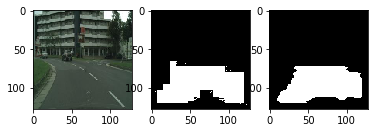

In [25]:
#for classification
def sigmoid(x):
    s = 1/(1+np.exp(-x)) 
    return s

Y_image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if Y_train[0, x , y ] > 0.5:
            Y_image[ x , y ] = [ 255 , 255 , 255 ]
        else:
            Y_image[ x , y ] = [ 0, 0, 0]    
            
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_train[0:1],tf_model.Y_input: Y_train[0:1]})
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if Y_pred[0, x , y ] > 0.5:
            image[ x , y ] = [ 255 , 255 , 255 ]
        else:
            image[ x , y ] = [ 0, 0, 0]
            
def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()
    
show_images( [ X_train[0], Y_image, image ] )

In [26]:
#performance Structural segmentation (four categories)
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val,tf_model.Y_input: Y_val}) #prediction
Y_pred = sigmoid(Y_pred)
mIoUs = []
intersection = []
union = []
for i in range(len(Y_val)):
    a = Y_pred[i]
    a = np.where(a.flatten()>0.5,1,0)
    b = Y_val[i].flatten()
    intersection=np.logical_and(a,b)
    union=np.logical_or(a,b)
    iou_score = np.sum(intersection) / np.sum(union)
    mIoUs.append(iou_score)
    sys.stdout.write('\r{} / {} : IoU = {}'.format(i, len(Y_val), iou_score))
    sys.stdout.flush()
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

198 / 500 : IoU = 0.81446882467955683

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


499 / 500 : IoU = 0.70210993892282075===> mIoU: 72.21


In [7]:
#https://github.com/wasidennis/AdaptSegNet/blob/master/compute_iou.py
#https://blog.csdn.net/jiongnima/article/details/84750819
info = {"classes":19,
  "label2train":[[0, 255],[1, 255], [2, 255],[3, 255],[4, 255],[5, 255],[6, 255],[7, 0],[8, 1],[9, 255],[10, 255],
                 [11, 2],[12, 3],[13, 4],[14, 255],[15, 255],[16, 255],[17, 5],[18, 255],[19, 6],[20, 7],
                 [21, 8],[22, 9],[23, 10],[24, 11],[25, 12],[26, 13],[27, 14],[28, 15],[29, 255],[30, 255],
                 [31, 16],[32, 17],[33, 18],[-1, 255]],
  "label":[ "road","sidewalk","building","wall","fence","pole","light","sign","vegetation","terrain",
            "sky","person","rider","car","truck","bus","train","motocycle","bicycle"],
  "palette":[ [128,64,128],[244,35,232],[70,70,70],[102,102,156],[190,153,153],[153,153,153],[250,170,30],[220,220,0],
              [107,142,35],[152,251,152],[70,130,180],[220,20,60],[255,0,0],[0,0,142],[0,0,70],[0,60,100],[0,80,100],
              [0,0,230],[119,11,32],[0,0,0]],
  "mean":[73.158359210711552,82.908917542625858,72.392398761941593],
  "std":[ 47.675755341814678,48.494214368814916,47.736546325441594]
}
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    t = (n * a[k] + b[k]).astype(int)
    return np.bincount(t, minlength=n ** 2).reshape(n, n)


def per_class_iu(hist):
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


def label_mapping(label, mapping):
    output = np.copy(label)
    for ind in range(len(mapping)):
        output[label == mapping[ind][0]] = mapping[ind][1]
    return np.array(output, dtype=np.int64)


#Compute IoU given the predicted colorized images
num_classes = np.int(info['classes'])
print('Num classes', num_classes)
name_classes = np.array(info['label'], dtype=np.str)
mapping = np.array(info['label2train'], dtype=np.int)
hist = np.zeros((num_classes, num_classes))
mIoUs = []
image_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val,tf_model.Y_input: Y_val})
image_pred = tf_model.sess.run(tf.nn.softmax(image_pred)) #turn to softmax
tmp_image_pred = []
for i in range(len(image_pred)):
    a = image_pred[i]
    a_one_hot = tf.one_hot(tf.nn.top_k(a).indices, tf.shape(a)[2])#turn softmax to onehot 
    a = tf_model.sess.run(a_one_hot).astype(int)
    tmp_image_pred.append(a)
image_label = Y_val
image_pred =np.array(tmp_image_pred)
for ind in range(len(image_label)):
    pred = image_pred[ind]
    label = image_label[ind]
    label = label_mapping(label, mapping)
    if len(label.flatten()) != len(pred.flatten()):
        print('Skipping: len(gt) = {:d}, len(pred) = {:d}, {:s}, {:s}'.format(len(label.flatten()), len(pred.flatten()), label[ind], pred[ind]))
        continue
    hist += fast_hist(label.flatten(), pred.flatten(), num_classes)
    #if ind > 0 and ind % 100 == 0:
        #print('{:d} / {:d}: {:0.2f}'.format(ind, len(image_label), 100*np.mean(per_class_iu(hist))))
    
mIoUs = per_class_iu(hist)
for ind_class in range(num_classes):
    print('===>' + name_classes[ind_class] + ':\t' + str(round(mIoUs[ind_class] * 100, 2)))
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

Num classes 19
===>road:	nan
===>sidewalk:	nan
===>building:	nan
===>wall:	nan
===>fence:	nan
===>pole:	nan
===>light:	nan
===>sign:	nan
===>vegetation:	nan
===>terrain:	nan
===>sky:	nan
===>person:	nan
===>rider:	nan
===>car:	nan
===>truck:	nan
===>bus:	nan
===>train:	nan
===>motocycle:	nan
===>bicycle:	nan
===> mIoU: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
